```
This software is part of GPU Ocean. 

Copyright (C) 2018 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate computational performance for
different block sizes for all four numerical schemes, as reported under 
Section 4.8 Computational Efficiency in Test Cases for Rotational 
Shallow-Water Schemes by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Performance: Block Size Experiment

This notebook runs a few timesteps of each of the four numerical schemes on a range of different OpenCL block sizes.
The efficiency of each simulation run is reported in a text file, which is later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the optimalization results.

### To find your own optimal block sizes
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time
import pyopencl
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique filename
test_filename = "blocksize_benchmark_run_0.txt"
file_test = 0
while (os.path.isfile(test_filename)):

    test_filename = "opencl_original_blocksize_benchmark_run_" + str(file_test) + ".txt"
    file_test += 1
    
    
#Use the existing file, do not generate new data
#test_filename = "blocksize_benchmark_run_7.txt"
#test_filename = "blocksize_tuned_opencl_desktop_cdklm.txt"
print("Storing data in " + test_filename)

Storing data in opencl_original_blocksize_benchmark_run_0.txt


In [3]:
def runBenchmark(filename):
    #sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    sim = np.array(["FBL", "CTCS", "CDKLM"])
    block_width = np.array([4, 8, 12, 16, 24, 32])
    block_height = np.array([4, 8, 12, 16, 24, 32])
    #block_width = np.array([4])
    #block_height = np.array([32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))
    
    python_cmd = "python"
    if sys.version_info.major == 2:
        python_cmd = "python2"

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    
                    tic = time.time()
                    
                    test_file.write("=========================================\n")
                    test_file.write(sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j]))
                    test_file.write("-----------------------------------------\n")
                    cmd = [ python_cmd, "run_benchmark.py", "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]), 
                           "--simulator", sim[k], "--steps_per_download", "200"]
                           #, "--nx", "100", "--ny", "100", "--steps_per_download", "100"]
                    p = subprocess.Popen(cmd, shell=False, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                    output = p.stdout.read()
                    test_file.write(str(output) + "\n")
                    test_file.write("=========================================\n")
                    test_file.write("\n")
                    
                    toc = time.time()
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)


if not (os.path.isfile(test_filename)):
    runBenchmark(test_filename)
else:
    print("Using existing run in " + test_filename)

Running with the following:
Widths: [ 4  8 12 16 24 32]
Heights: [ 4  8 12 16 24 32]
FBL [04 x 04] completed in 6.05 s

FBL [04 x 08] completed in 4.45 s

FBL [04 x 12] completed in 4.04 s

FBL [04 x 16] completed in 3.72 s

FBL [04 x 24] completed in 3.62 s

FBL [04 x 32] completed in 3.62 s

FBL [08 x 04] completed in 4.27 s

FBL [08 x 08] completed in 3.56 s

FBL [08 x 12] completed in 3.32 s

FBL [08 x 16] completed in 3.23 s

FBL [08 x 24] completed in 3.28 s

FBL [08 x 32] completed in 3.25 s

FBL [12 x 04] completed in 3.78 s

FBL [12 x 08] completed in 3.36 s

FBL [12 x 12] completed in 3.26 s

FBL [12 x 16] completed in 3.25 s

FBL [12 x 24] completed in 3.31 s

FBL [12 x 32] completed in 3.24 s

FBL [16 x 04] completed in 3.49 s

FBL [16 x 08] completed in 3.16 s

FBL [16 x 12] completed in 3.20 s

FBL [16 x 16] completed in 3.16 s

FBL [16 x 24] completed in 3.28 s

FBL [16 x 32] completed in 3.28 s

FBL [24 x 04] completed in 3.48 s

FBL [24 x 08] completed in 3.34 s

FBL [

In [4]:
def getData(filename):
    # State variables
    simulator = None
    block_width = None
    block_height = None

    data = np.empty((0, 4))

    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)

            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)

            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                data = np.append(data, [[simulator, block_width, block_height, megacells]], axis=0)
                
                block_width = None
                block_height = None

    return data

data = getData(test_filename)
print(data)

[['FBL' '04' '04' '269.52100845']
 ['FBL' '04' '08' '488.77311922']
 ['FBL' '04' '12' '631.62553692']
 ['FBL' '04' '16' '826.47637574']
 ['FBL' '04' '24' '933.02968349']
 ['FBL' '04' '32' '944.30303070']
 ['FBL' '08' '04' '537.52370606']
 ['FBL' '08' '08' '983.49983169']
 ['FBL' '08' '12' '1308.24740758']
 ['FBL' '08' '16' '1466.69935227']
 ['FBL' '08' '24' '1418.96556185']
 ['FBL' '08' '32' '1438.74234414']
 ['FBL' '12' '04' '775.08348160']
 ['FBL' '12' '08' '1308.04410694']
 ['FBL' '12' '12' '1438.19247184']
 ['FBL' '12' '16' '1516.11554178']
 ['FBL' '12' '24' '1517.16416491']
 ['FBL' '12' '32' '1474.81708919']
 ['FBL' '16' '04' '1045.85128609']
 ['FBL' '16' '08' '1730.71715434']
 ['FBL' '16' '12' '1633.12274743']
 ['FBL' '16' '16' '1700.58662894']
 ['FBL' '16' '24' '1601.90365591']
 ['FBL' '16' '32' '1619.70528934']
 ['FBL' '24' '04' '1372.64477453']
 ['FBL' '24' '08' '1559.71125826']
 ['FBL' '24' '12' '1670.29224530']
 ['FBL' '24' '16' '1523.16002530']
 ['FBL' '24' '24' '1413.29602

['04' '08' '12' '16' '24' '32']
CDKLM
         04       08       12       16       24       32
04  109.355  120.812    121.3  120.002  108.515  141.236
08  129.795   153.55  155.162  154.468  148.868   99.803
12  134.907  152.725  169.977  151.844  110.579  145.401
16  133.433  160.069  158.312  106.861  148.787      NaN
24  120.656  156.164  115.572  152.211      NaN      NaN
32  177.217  119.038  169.961      NaN      NaN      NaN
Maximum=177.22
Minimum=99.80
Mean=138.22
CTCS
         04       08       12       16       24       32
04  162.138  282.045  375.271  479.806   590.63  588.875
08  302.536  540.076  730.626  838.867  796.174  816.766
12  439.565  762.465  802.989   843.06  859.004  818.028
16  566.493  925.492  877.855  911.817  860.305   856.11
24  797.047  891.694  910.034  870.662  773.034  692.507
32  1005.92  995.662  904.258  948.229  762.323  867.908
Maximum=1005.92
Minimum=162.14
Mean=734.62
FBL
         04       08       12       16       24       32
04  269.521  4

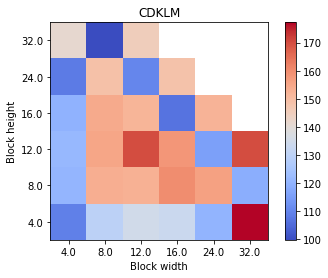

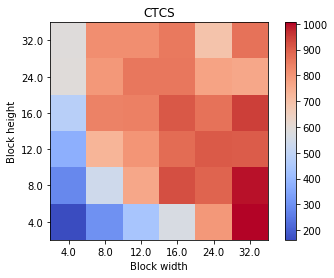

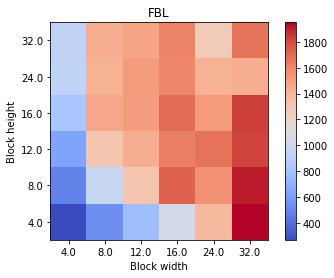

In [5]:
simulators = np.unique(data[:,0])
block_widths = np.unique(data[:,1])
block_heights = np.unique(data[:,2])

print(block_widths)

for simulator in simulators:
    print(simulator)
    
    df = pd.DataFrame(index=block_widths, columns=block_heights)

    # Pick this simulator data only and sort into a dataframe
    columns = data[:,0] == simulator
    for record in data[columns]:
        block_width = record[1]
        block_height = record[2]
        megacells = np.float32(record[3])
        df[block_height][block_width] = megacells
        
    maximum = np.nanmax(df.values)
    minimum = np.nanmin(df.values)
    mean = np.nanmean(df.values)
    print(df)
    print("Maximum={:.2f}".format(maximum))
    print("Minimum={:.2f}".format(minimum))
    print("Mean={:.2f}".format(mean))

    # Plot dataframe
    x = df.index.values.astype(np.float32)
    y = df.columns.values.astype(np.float32)
    z = np.transpose(df.values.astype(np.float32))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    img = ax.imshow(z, origin='lower', cmap=cm.coolwarm, interpolation="None")
    plt.colorbar(img)
    plt.xticks( range(len(x)), x )
    ax.set_xlabel('Block width')
    plt.yticks( range(len(y)), y )
    ax.set_ylabel('Block height')
    plt.title(simulator)
    plt.savefig(test_filename.replace('.txt', '.png'))
    